In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression, MultiTaskLasso, Lasso, MultiTaskElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.ensemble import RandomForestRegressor

# Machine Learning the Spectrum of X-ray Binaries

This notebook aims to investigate whether X-ray colours measured by the Chandra X-ray Observatory can be used to infer spectral parameters—specifically the hydrogen column density ($N_H$) and the photon index ($\Gamma$)—using machine learning techniques.

We explore three regression models to map hard and soft X-ray colour ratios to spectral parameters:
- Polynomial Regression
- K-Nearest Neighbors Regression (KNN)
- Random Forest Regression (RFR)

We also evaluate the effect of instrumental degradation by comparing results across two observational cycles from Chandra: Cycle 3 (early) and Cycle 25 (recent).


## Getting and visualising the data

The dataset consists of simulated X-ray spectra generated using varying values of $N_H$ and $\Gamma$. From these spectra, we extract X-ray colours defined as:

- **Soft colour ($C_S$)**:  
  $$
  C_S = \frac{M - S}{M + S}
  $$

- **Hard colour ($C_H$)**:  
  $$
  C_H = \frac{H - M}{H + M}
  $$

Here, $S$, $M$, and $H$ are photon counts in the soft (0.5–1 keV), medium (1–2 keV), and hard (2–7 keV) energy bands, respectively.

These colour ratios act as proxies for the underlying spectral parameters and offer a robust alternative to direct spectral fitting, especially in low-count or high-uncertainty observations.

In [2]:
def read_data(file):
    """
    Reads data from a CSV file, processes it by normalizing columns and adding new transformations,
    and returns the modified DataFrame.

    Inputs:
    - file (str): Path to the input CSV file.

    Outputs:
    - data (DataFrame): Processed DataFrame with new columns and transformations.
    """
    
    data = pd.read_csv(file, index_col='Unnamed: 0')
    
    # Normalize 'hard' and 'soft' columns
    data['hard'] = (data['hard'] - data['medium']) / (data['hard'] + data['medium'])
    data['soft'] = (-data['soft'] + data['medium']) / (data['soft'] + data['medium'])
    
    points = pd.read_csv('points.csv', index_col='Unnamed: 0')
    
    # Merge with additional points data
    data = pd.concat([data, points], axis=1)
    
    # Drop 'medium' column and add log(NH)
    data = data.drop('medium', axis=1)
    data['log(NH)'] = np.log10(data['NH'])
    
    return data


In [3]:
data3=read_data('points_results_cycle3.csv')

/Users/Eli/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Cycle 3')

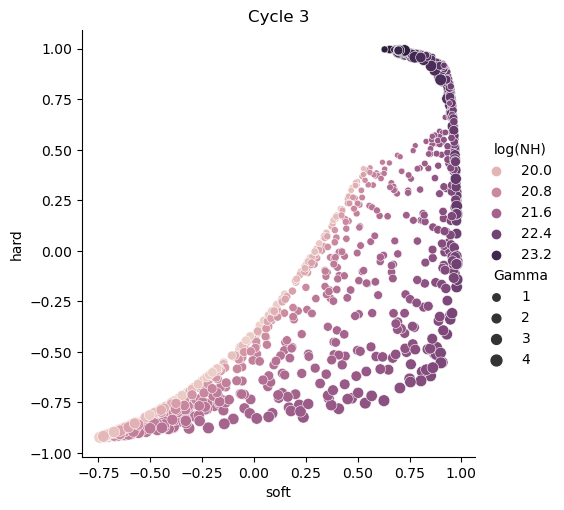

In [4]:
sns.relplot(data=data3, x='soft', y='hard', size='Gamma', hue='log(NH)')
plt.title('Cycle 3')

/Users/Eli/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<function matplotlib.pyplot.show(close=None, block=None)>

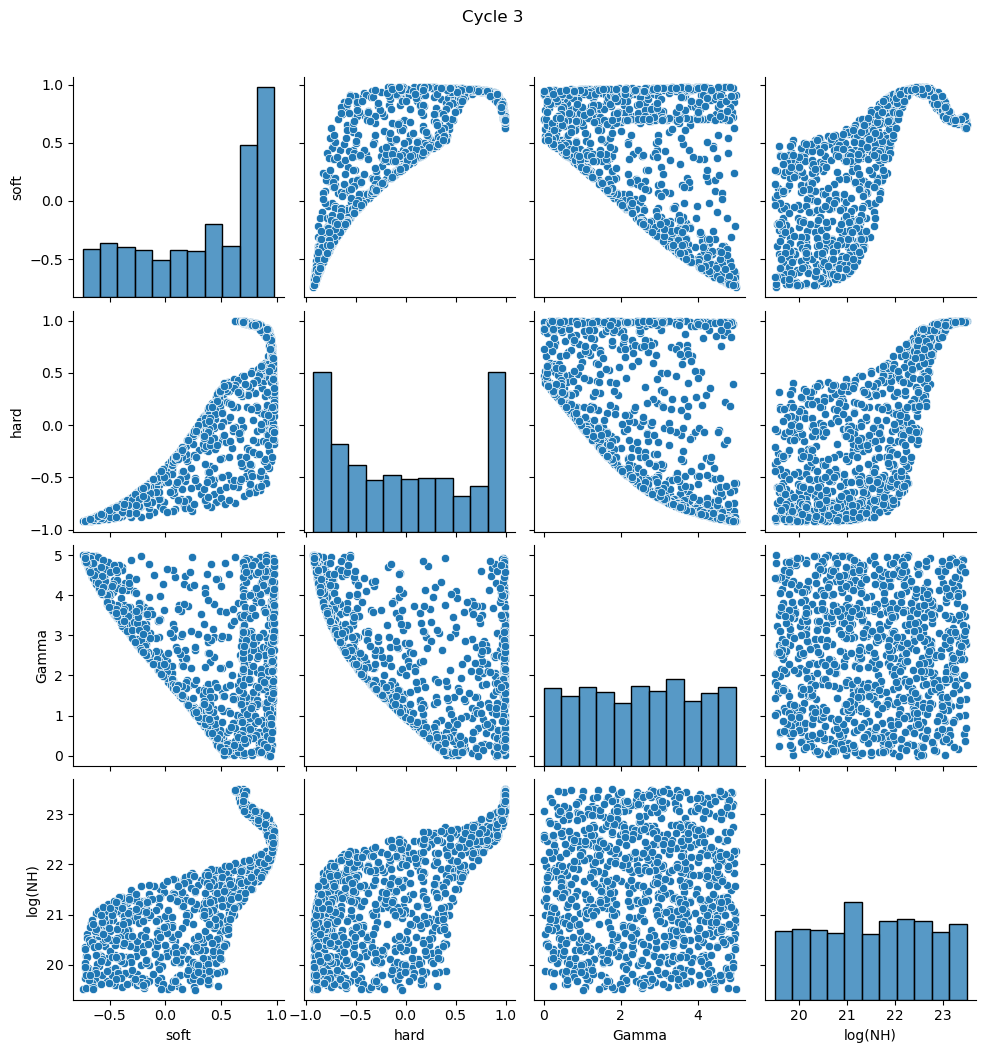

In [5]:
sns.pairplot(data3.drop('NH', axis=1)).fig.suptitle('Cycle 3', y=1.05)
plt.show

You can use the following function to split the data:

In [6]:
def split(data):
    X=np.array(data.loc[:,['hard', 'soft']])
    y=np.array(data.loc[:,['Gamma', 'log(NH)']], dtype=float)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
    return x_train, x_test, y_test, y_train

Run it by taking the hashtag out of the following line of code:

In [7]:
#x_train3, x_test3, y_test3, y_train3=split(data3)

For the code I will be using the same split as seen in the documentation:

In [8]:
def readsplit(trainfile, testfile):
    """
    Reads training and testing data from CSV files, splits them into feature and target arrays,
    and returns the training and testing datasets.

    Inputs:
    - trainfile (str): Path to the training CSV file.
    - testfile (str): Path to the testing CSV file.

    Outputs:
    - x_train (array): Feature data for training.
    - y_train (array): Target data for training.
    - x_test (array): Feature data for testing.
    - y_test (array): Target data for testing.
    """
    
    train = pd.read_csv(trainfile, index_col='Unnamed: 0')
    x_train = np.array(train.loc[:, ['hard', 'soft']])
    y_train = np.array(train.loc[:, ['Gamma', 'log(NH)']])
    
    test = pd.read_csv(testfile, index_col='Unnamed: 0')
    x_test = np.array(test.loc[:, ['hard', 'soft']])
    y_test = np.array(test.loc[:, ['Gamma', 'log(NH)']])
    
    return x_train, y_train, x_test, y_test


In [9]:
x_train3, y_train3, x_test3, y_test3=readsplit('train3.csv', 'test3.csv')

## Machine Learning Approach

We aim to map X-ray colours ($C_H$, $C_S$) to the spectral parameters $N_H$ and $\Gamma$. Three machine learning regressors are evaluated:

- **Polynomial Regression**: Flexible for modeling smooth, structured data.
- **K-Nearest Neighbors Regression (KNN)**: A non-parametric model relying on local patterns.
- **Random Forest Regression (RFR)**: An ensemble method robust to non-linearities and scaling issues.

Each model is optimized using **5-fold cross-validation** and **hyperparameter tuning** to ensure generalization and avoid overfitting.


### Polynomial Regression

We begin with polynomial regression since the dataset is smooth and grid-like, with only a few complex areas (e.g., the "tail"). This method models the relationship between features and targets as an $n$-degree polynomial:

$$
y = \beta_0 + \beta_1 x + \beta_2 x^2 + \cdots + \beta_n x^n
$$

Tuning the polynomial degree is crucial: a degree that is too low will underfit the data, while a high degree risks overfitting by capturing noise.


In [10]:
def kfoldhyperpoly(x_train, x_test, y_test, y_train, max_degree):
    """
    Performs k-fold cross-validation to determine the optimal polynomial degree for a regression model
    and evaluates the model on test data.

    Inputs:
    - x_train (array): Training features.
    - x_test (array): Testing features.
    - y_train (array): Training target values.
    - y_test (array): Testing target values.
    - max_degree (int): Maximum degree of polynomial features to test.

    Outputs:
    - optimal_degree (int): Optimal polynomial degree based on cross-validation error.
    - model (LinearRegression): The fitted regression model with the optimal degree.
    - test_score (float): Test score for the optimal degree.
    """
    
    R = pd.DataFrame(columns=['test', 'CV'], index=np.arange(1, max_degree + 1))
    
    for i in range(1, max_degree + 1):
        poly = PolynomialFeatures(degree=i, include_bias=False)
        poly_train = poly.fit_transform(x_train)
        poly_test = poly.fit_transform(x_test)
        
        # Define and fit model with cross-validation
        model = LinearRegression()
        cve = cross_validate(model, poly_train, y_train, cv=5, return_train_score=True)
        
        R['CV'][i] = np.mean(np.absolute(cve['test_score']))
        
        # Fit model and evaluate on test data
        model.fit(poly_train, y_train)
        R['test'][i] = model.score(poly_test, y_test)
        
        # If the cross-validation R^2 starts to decrease stop and return model
        if (i != 1) and (R['CV'][i] < R['CV'][i-1]):
            poly = PolynomialFeatures(degree=i-1, include_bias=False)
            poly_train = poly.fit_transform(x_train)
            model = LinearRegression()
            model.fit(poly_train, y_train)
            return i-1, model, R['test'][i-1]

In [11]:
deg3, model3, r23p=kfoldhyperpoly(x_train3, x_test3, y_test3, y_train3, 20)

In [12]:
r23p

0.9339225590487645

In [13]:
deg3

11

### K-Nearest Neighbors Regression

While polynomial regression provides a good baseline, it struggles with extrapolation. To assess this limitation, we try KNN regression, which makes predictions based on the average of the $k$ nearest neighbors in the feature space.

This method is particularly useful for understanding local relationships, but its performance depends strongly on the choice of $k$ and the distance metric.


In [14]:
def hyperknn(x_train, x_test, y_test, y_train, max_neighbors):
    """
    Performs k-fold cross-validation to determine the optimal number of neighbors for a KNN regression model
    and evaluates the model on test data.

    Inputs:
    - x_train (array): Training features.
    - x_test (array): Testing features.
    - y_train (array): Training target values.
    - y_test (array): Testing target values.
    - max_neighbors (int): Maximum number of neighbors to test.

    Outputs:
    - optimal_neighbors (int): Optimal number of neighbors based on cross-validation error.
    - model (KNeighborsRegressor): The fitted KNN model with the optimal number of neighbors.
    - test_score (float): Test score for the optimal number of neighbors.
    """
    
    R = pd.DataFrame(columns=['test', 'CV'], index=np.arange(1, max_neighbors + 1))
    
    for i in range(1, max_neighbors + 1):
        # Define and fit model
        model = KNeighborsRegressor(n_neighbors=i)
        model.fit(x_train, y_train)
        
        # Cross-validation error
        cve = cross_validate(model, x_train, y_train, cv=5, return_train_score=True)
        R['CV'][i] = np.mean(np.absolute(cve['test_score']))
        
        # Evaluate on test data
        R['test'][i] = model.score(x_test, y_test)
        
        # If the cross-validation R^2 starts to decrease stop and return model
        if (i != 1) and (R['CV'][i] < R['CV'][i-1]):
            model = KNeighborsRegressor(n_neighbors=i-1)
            model.fit(x_train, y_train)
            return i-1, model, R['test'][i-1]

In [15]:
nei3, modelknn, r23=hyperknn(x_train3, x_test3, y_test3, y_train3, 20)

In [16]:
r23

0.9204992835647559

In [17]:
nei3

2

### Random Forest Regression

KNN performance can degrade due to sensitivity to scaling and the definition of "distance" in feature space. Random Forest Regression (RFR) avoids this by relying on decision trees, which split the data based on feature thresholds.

RFR builds an ensemble of trees trained on bootstrapped samples and averages their predictions, making it robust to outliers and capable of capturing non-linear trends.


In [18]:
def RFR(x_train, x_test, y_test, y_train):
    """
    Tunes the Random Forest Regressor by testing different numbers of estimators and max depths using cross-validation,
    and returns the best model with the corresponding parameters.

    Inputs:
    - x_train (array): Training features.
    - x_test (array): Testing features.
    - y_train (array): Training target values.
    - y_test (array): Testing target values.

    Outputs:
    - best_est (int): Optimal number of estimators.
    - best_depth (int): Optimal max depth for the trees.
    - max_value (float): Best model's score.
    - model (RandomForestRegressor): Fitted Random Forest model with optimal parameters.
    """
    
    # Define the range of estimators and depths
    max_depth = np.arange(0, 25, 5)  # 0, 5, 10, 15, 20
    n_estimators = np.arange(100, 1100, 100)  # 100, 200, ..., 1000
    R = pd.DataFrame(index=max_depth, columns=n_estimators)
    R.index.name = "Max Depth"
    R.columns.name = "Number of Estimators"
    
    # Testing different numbers of estimators
    for n in n_estimators:
        model = RandomForestRegressor(n_estimators=n, max_depth=None)
        model.fit(x_train, y_train)
        R.loc[0, n] = model.score(x_test, y_test)
        
        # Testing different max depths
        for j in range(1, 5):
            model = RandomForestRegressor(n_estimators=n, max_depth=j*5)
            model.fit(x_train, y_train)
            R.loc[j*5][n] = model.score(x_test, y_test)
    
    # Find the maximum value in the DataFrame
    max_value = R.max().max()

    # Find the row and column positions of the maximum value
    max_row, max_col = np.where(R.values == max_value)
    best_est = n_estimators[max_col]
    best_depth = max_depth[max_row]
    
    # Set up the best model
    if best_depth == 0:
        model = RandomForestRegressor(n_estimators=int(best_est), max_depth=None) # Case depth equal zero seperate because max_depth has to be none not zero
    else:
        model = RandomForestRegressor(n_estimators=int(best_est), max_depth=int(best_depth))
    model.fit(x_train, y_train)
    
    return best_est, best_depth, max_value, model

In [19]:
n_est, depth, score, model=RFR(x_train3, x_test3, y_test3, y_train3)

In [20]:
score

0.9373486119199073

In [21]:
n_est

array([100])

In [22]:
depth

array([20])

In [23]:
print('Polynomial regressor:', r23p)
print('Knn regressor:', r23)
print('RFR regressor:', score)

Polynomial regressor: 0.9339225590487645
Knn regressor: 0.9204992835647559
RFR regressor: 0.9373486119199073


## Comparison of Regression Models

To compare performance, we trained and validated all models using Cycle 3 data, which provides a diverse distribution of X-ray colour values.

The evaluation metric used is the **$R^2$ score**, which measures how well the predicted values match the true values.

Below we print the best hyperparameters found for each model along with their $R^2$ scores on the test set.


In [24]:
# Print best hyperparameters and R² scores

print("🔧 Best Hyperparameters Found:")
print(f"  • Polynomial Regression: degree = {deg3}")
print(f"  • KNN Regression: n_neighbors = {nei3}")
print(f"  • Random Forest Regression: n_estimators = {n_est}, max_depth = {depth}")

print("\n📊 Test Set Performance (Cycle 3):")
print(f"  • Polynomial Regression: R² = {r23p:.4f}")
print(f"  • KNN Regression: R² = {r23:.4f}")
print(f"  • Random Forest Regression: R² = {score:.4f}")

🔧 Best Hyperparameters Found:
  • Polynomial Regression: degree = 11
  • KNN Regression: n_neighbors = 2
  • Random Forest Regression: n_estimators = [100], max_depth = [20]

📊 Test Set Performance (Cycle 3):
  • Polynomial Regression: R² = 0.9339
  • KNN Regression: R² = 0.9205
  • Random Forest Regression: R² = 0.9373


### Visualizing Model Performance

To better understand how each model performs, we generate two types of visualizations:

1. **Predicted vs Actual Scatter Plots**  
   These plots show how well each model’s predictions match the true values of $\log(N_H)$ and $\Gamma$. Ideal performance is indicated by points lying along the diagonal.

2. **Mean Absolute Error (MAE) Contour Maps**  
   These maps help identify regions in the colour–colour space where the models perform well or poorly. High-error areas reveal where predictions deviate most from the true values and may highlight regions with high observational uncertainty or complex spectral features.

Together, these visualizations allow us to assess both the **accuracy** and the **spatial consistency** of each regression model.


In [25]:
def panel(df, title):
    """
    Creates a side-by-side scatter plot comparing actual vs. predicted values for 'Gamma' and 'log(NH)'.

    Inputs:
    - df (DataFrame): The DataFrame containing actual and predicted values for 'Gamma', 'PGamma', 'log(NH)', and 'Plog(NH)'.
    - title (str): Title for the plot.

    Outputs:
    - Displays a plot with two scatter plots: one for 'Gamma' vs. 'PGamma' and another for 'log(NH)' vs. 'Plog(NH)'.
    """
    
    # Plot actual vs. predicted 'Gamma'
    plt.subplot(1, 2, 1)
    min_val = min(df['Gamma'].min(), df['PGamma'].min())
    max_val = max(df['Gamma'].max(), df['PGamma'].max())
    plt.scatter(df['Gamma'], df['PGamma'])
    plt.xlabel("Actual gamma")
    plt.ylabel("Predicted gamma")
    plt.grid(False)
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="1-to-1 Line")
    plt.xlim(df['Gamma'].min()-0.5, df['Gamma'].max()+0.5)
    
    # Plot actual vs. predicted 'log(NH)'
    plt.subplot(1, 2, 2)
    min_val = min(df['log(NH)'].min(), df['Plog(NH)'].min())
    max_val = max(df['log(NH)'].max(), df['Plog(NH)'].max())
    plt.scatter(df['log(NH)'], df['Plog(NH)'])
    plt.xlabel("Actual log(NH)")
    plt.ylabel("Predicted log(NH)")
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="1-to-1 Line")
    plt.xlim(df['log(NH)'].min()-0.5, df['log(NH)'].max()+0.5)
    
    # Adjust layout and display
    plt.grid(False)
    plt.subplots_adjust(wspace=0.3)
    plt.suptitle(title)
    plt.tight_layout()

In [26]:
# Generating predictions from multiple models and storing the actual and predicted values in separate DataFrames

# Predictions from the Random Forest model
ypred3RFR=model.predict(x_test3)
poly3=PolynomialFeatures(degree=deg3, include_bias=False)
RFR=pd.DataFrame()
RFR['Gamma']=y_test3[:,0]
RFR['log(NH)']=y_test3[:,1]
RFR['PGamma']=ypred3RFR[:,0]
RFR['Plog(NH)']=ypred3RFR[:,1]

# Predictions using polynomial features
poly_features3=poly3.fit_transform(x_test3)
ypred3p=model3.predict(poly_features3)
poly=pd.DataFrame()
poly['Gamma']=y_test3[:,0]
poly['log(NH)']=y_test3[:,1]
poly['PGamma']=ypred3p[:,0]
poly['Plog(NH)']=ypred3p[:,1]

# Predictions from the KNN model
ypredknn=modelknn.predict(x_test3)
KNN=pd.DataFrame()
KNN['Gamma']=y_test3[:,0]
KNN['log(NH)']=y_test3[:,1]
KNN['PGamma']=ypredknn[:,0]
KNN['Plog(NH)']=ypredknn[:,1]

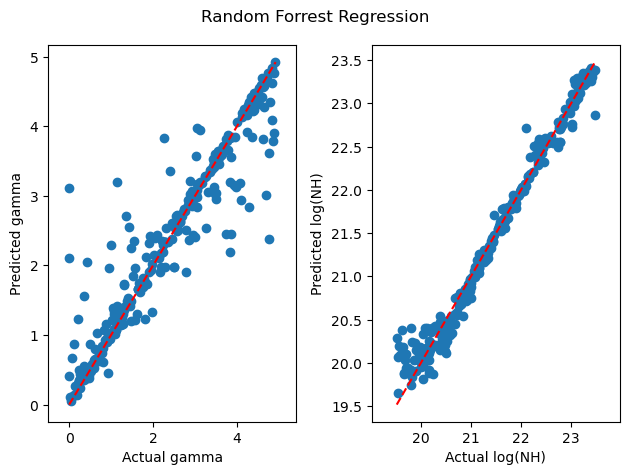

In [27]:
panel(RFR, "Random Forrest Regression")

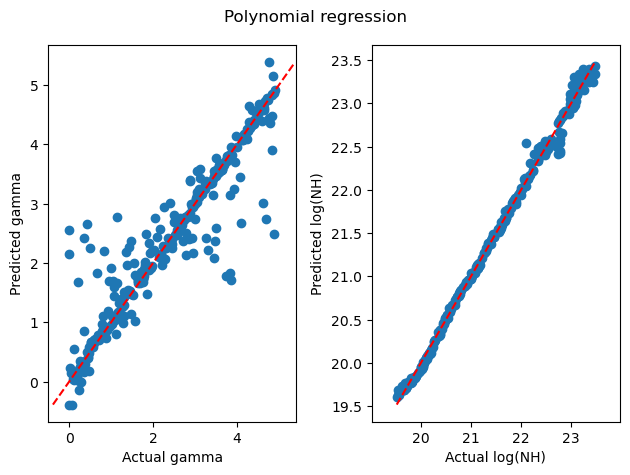

In [28]:
panel(poly, "Polynomial regression")

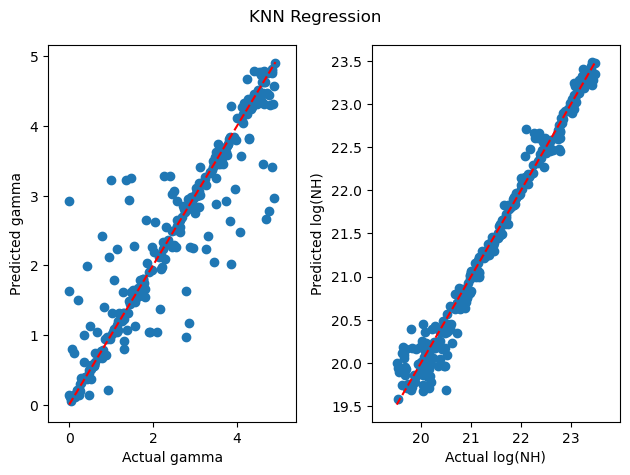

In [29]:
panel(KNN, "KNN Regression")

In [30]:
def contour(df, title, num_bins_x=15, num_bins_y=15, cmap="plasma"):
    """
    Plots a 2D contour map of the combined Mean Absolute Error (MAE) 
    between actual and predicted values in the input DataFrame.
    
    Parameters:
    - df (DataFrame): The input data with columns 'Gamma', 'log(NH)', 'PGamma', 'Plog(NH)'
    - num_bins_x (int): Number of bins for the 'Gamma' axis (default: 15)
    - num_bins_y (int): Number of bins for the 'log(NH)' axis (default: 15)
    - cmap (str): Colormap to use for the contour plot (default: "plasma")
    """
    
    # Calculate the total MAE as the sum of the absolute errors for each variable
    df['MAE'] = (np.abs(df['Gamma'] - df['PGamma']) + np.abs(df['log(NH)'] - df['Plog(NH)']))
    
    # Define grid parameters for 2D contour plotting
    x_bins = np.linspace(df['Gamma'].min(), df['Gamma'].max(), num_bins_x)
    y_bins = np.linspace(df['log(NH)'].min(), df['log(NH)'].max(), num_bins_y)
    
    # Initialize 2D grid for combined MAE values
    mae_grid = np.zeros((len(x_bins) - 1, len(y_bins) - 1))
    
    # Calculate mean MAE for each bin in the 2D grid
    for i in range(len(x_bins) - 1):
        for j in range(len(y_bins) - 1):
            # Get data points within the current bin
            mask = (
                (df['Gamma'] >= x_bins[i]) & (df['Gamma'] < x_bins[i + 1]) &
                (df['log(NH)'] >= y_bins[j]) & (df['log(NH)'] < y_bins[j + 1])
            )
            
            # Calculate mean combined MAE in this zone
            if mask.sum() > 0:  # Ensure there are points in the bin
                mae_grid[i, j] = df[mask]['MAE'].mean()
            else:
                mae_grid[i, j] = np.nan  # Assign NaN if no data points in bin
    
    # Create meshgrid for plotting
    X, Y = np.meshgrid(x_bins[:-1], y_bins[:-1])
    
    # Plot the contour map for the combined MAE
    plt.figure(figsize=(8, 6))
    contour = plt.contourf(X, Y, mae_grid.T, cmap=cmap, levels=30)
    plt.colorbar(contour, label="Mean Absolute Error")
    plt.xlabel('Gamma')
    plt.ylabel('log(NH)')
    plt.title(title)
    plt.show()

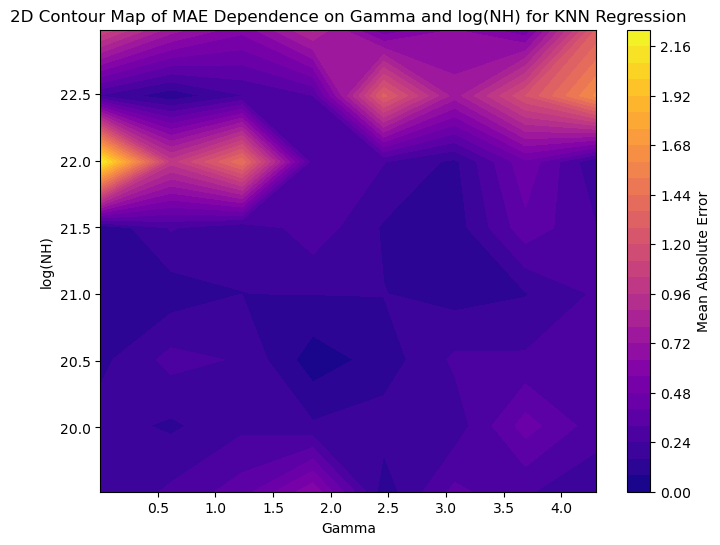

In [31]:
contour(KNN, num_bins_x=9, num_bins_y=9, cmap="plasma", title='2D Contour Map of MAE Dependence on Gamma and log(NH) for KNN Regression')

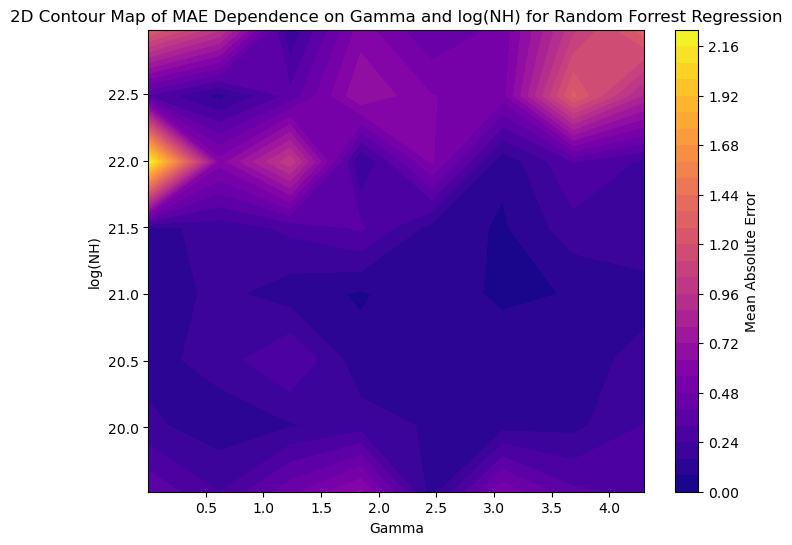

In [32]:
contour(RFR, num_bins_x=9, num_bins_y=9, cmap="plasma", title='2D Contour Map of MAE Dependence on Gamma and log(NH) for Random Forrest Regression')

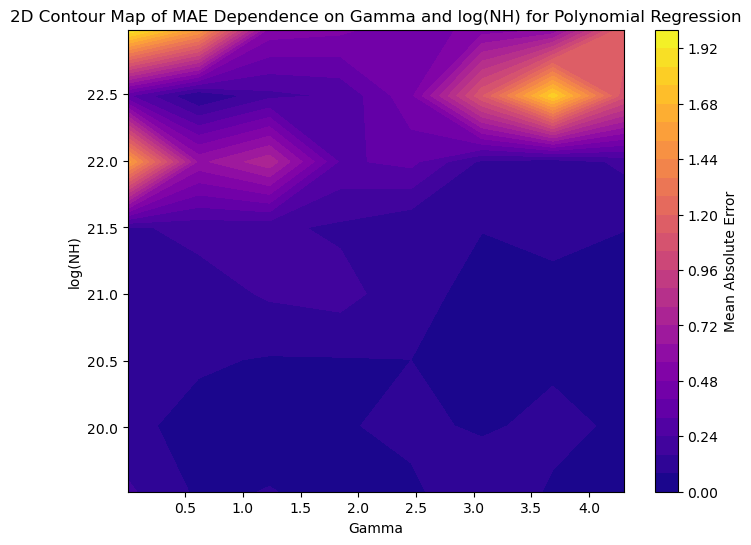

In [33]:
contour(poly, num_bins_x=9, num_bins_y=9, cmap="plasma", title='2D Contour Map of MAE Dependence on Gamma and log(NH) for Polynomial Regression')

## Testing Generalization Across Observation Cycles

The Chandra Observatory has experienced degradation over time, particularly in its soft X-ray sensitivity. To evaluate whether a model trained on one observation cycle generalizes to another, we compare two polynomial regression models and two KNN models (to ensure that the results are not model-specific):

- Model 3: Trained on Cycle 3 (early mission)
- Model 25: Trained on Cycle 25 (later mission)

Each model is tested on the dataset from the **opposite** cycle to assess the effect of instrumental changes on spectral inference.


In [34]:
data25=read_data('points_results_current_cycle.csv')

In [35]:
x_train25, y_train25, x_test25, y_test25=readsplit('train25.csv', 'test25.csv')

In [36]:
train25data = pd.DataFrame()
train25data['hard'] = x_train25[:, 0]
train25data['soft'] = x_train25[:, 1]
train25data['Gamma'] = y_train25[:, 0]
train25data['log(NH)'] = y_train25[:, 1]
train25data.to_csv('train25.csv')

test25data = pd.DataFrame()
test25data['hard'] = x_test25[:, 0]
test25data['soft'] = x_test25[:, 1]
test25data['Gamma'] = y_test25[:, 0]
test25data['log(NH)'] = y_test25[:, 1]
test25data.to_csv('test25.csv')


In [37]:
deg25, model25, r225=kfoldhyperpoly(x_train25, x_test25, y_test25, y_train25, 20)

In [38]:
deg25

9

In [39]:
poly3=PolynomialFeatures(degree=deg3, include_bias=False)
poly25=PolynomialFeatures(degree=deg25, include_bias=False)
poly_features33=poly3.fit_transform(x_test3)
ypred33=model3.predict(poly_features33)
print('Using model 3 on dataset 3:', 'R^2:', model3.score(poly_features33, y_test3), ', msa:', mae(y_test3, ypred33))
poly_features2525=poly25.fit_transform(x_test25)
ypred2525=model25.predict(poly_features2525)
print('Using model 25 on dataset 25:', 'R^2:', model25.score(poly_features2525, y_test25), ', msa:', mae(y_test25, ypred2525)) 
poly_features253=poly3.fit_transform(x_test25)
ypred253=model3.predict(poly_features253)
poly_features325=poly25.fit_transform(x_test3)
ypred325=model25.predict(poly_features325)
print('Using model 3 on dataset 25:', 'R^2:', model3.score(poly_features253, y_test25), ', msa:', mae(y_test25, ypred253)) 
print('Using model 25 on dataset 3:', 'R^2:', model25.score(poly_features325, y_test3), ', msa:', mae(y_test3, ypred325))

Using model 3 on dataset 3: R^2: 0.9339225590487645 , msa: 0.15453410798105996
Using model 25 on dataset 25: R^2: 0.9339592657359279 , msa: 0.18851241851208994
Using model 3 on dataset 25: R^2: 0.5013001562711258 , msa: 0.5545679490498017
Using model 25 on dataset 3: R^2: -1922306625236.1035 , msa: 583263.0722415921


### Cross-Cycle Prediction Accuracy

We visualize the predicted vs actual values of $\log(N_H)$ and $\Gamma$ for both cross-cycle applications:

- Model 3 applied to Cycle 25
- Model 25 applied to Cycle 3

These comparisons reveal whether the models retain predictive power when applied outside their training conditions.


In [40]:
dfm3c25=pd.DataFrame()
dfm3c25['Gamma']=y_test25[:,0]
dfm3c25['log(NH)']=y_test25[:,1]
dfm3c25['PGamma']=ypred253[:,0]
dfm3c25['Plog(NH)']=ypred253[:,1]

In [41]:
dfm25c3=pd.DataFrame()
dfm25c3['Gamma']=y_test3[:,0]
dfm25c3['log(NH)']=y_test3[:,1]
dfm25c3['PGamma']=ypred325[:,0]
dfm25c3['Plog(NH)']=ypred325[:,1]

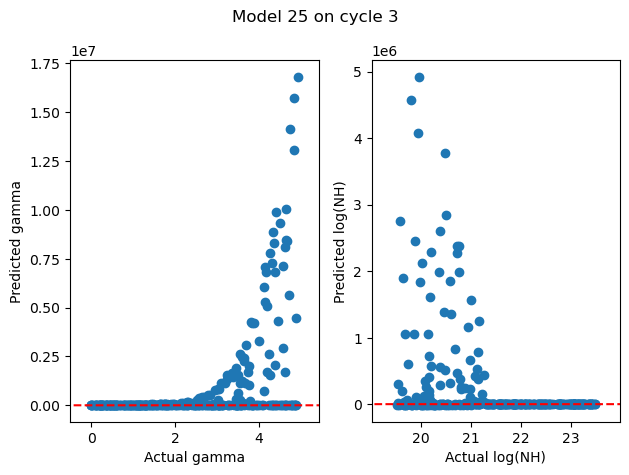

In [42]:
panel(dfm25c3, "Model 25 on cycle 3")

In [43]:
def panelz(df, title):
    """
    Creates side-by-side scatter plots comparing actual vs. predicted values for 'Gamma' and 'log(NH)', with zoomed-in axes.

    Inputs:
    - df (DataFrame): DataFrame containing actual and predicted values for 'Gamma', 'PGamma', 'log(NH)', and 'Plog(NH)'.
    - title (str): Title for the plot.

    Outputs:
    - Displays a plot with two scatter plots: one for 'Gamma' vs. 'PGamma' and another for 'log(NH)' vs. 'Plog(NH)'.
    """
    
    # Plot actual vs. predicted 'Gamma' (zoomed version)
    plt.subplot(1, 2, 1)
    min_val = min(df['Gamma'].min(), df['PGamma'].min())
    max_val = max(df['Gamma'].max(), df['PGamma'].max())
    plt.scatter(df['Gamma'], df['PGamma'])
    plt.grid(False)
    plt.xlabel("Actual gamma")
    plt.ylabel("Predicted gamma")
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="1-to-1 Line")
    plt.xlim(df['Gamma'].min() - 0.5, df['Gamma'].max() + 0.5)
    plt.ylim(0, 5)
    
    # Plot actual vs. predicted 'log(NH)' (zoomed version)
    plt.subplot(1, 2, 2)
    min_val = min(df['log(NH)'].min(), df['Plog(NH)'].min())
    max_val = max(df['log(NH)'].max(), df['Plog(NH)'].max())
    plt.scatter(df['log(NH)'], df['Plog(NH)'])
    plt.xlabel("Actual log(NH)")
    plt.ylabel("Predicted log(NH)")
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="1-to-1 Line")
    plt.xlim(df['log(NH)'].min() - 0.5, df['log(NH)'].max() + 0.5)
    plt.ylim(20, 25)
    
    # Adjust layout and display
    plt.subplots_adjust(wspace=0.3)
    plt.grid(False)
    plt.suptitle(title)
    plt.tight_layout()


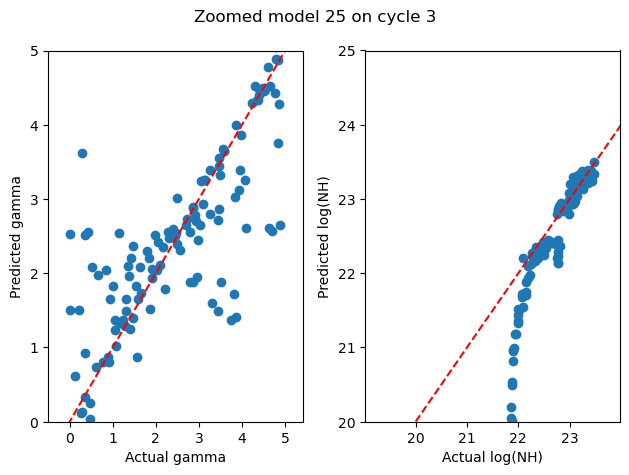

In [44]:
panelz(dfm25c3, "Zoomed model 25 on cycle 3")

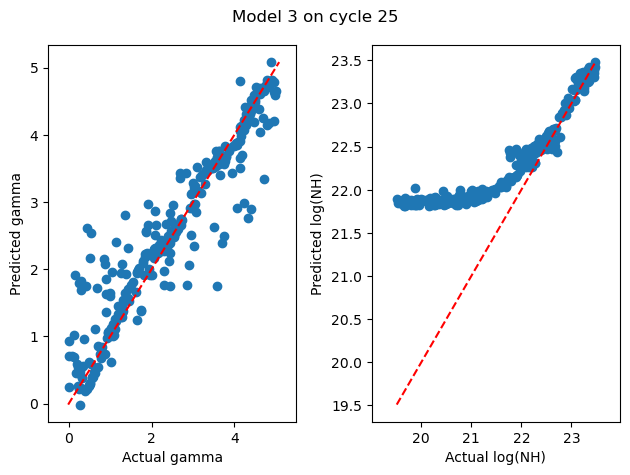

In [45]:
panel(dfm3c25, "Model 3 on cycle 25")

KNN

In [46]:
deg3, model3, r23=hyperknn(x_train3, x_test3, y_test3, y_train3, 20)

In [47]:
deg25, model25, r225=hyperknn(x_train25, x_test25, y_test25, y_train25, 20)

In [48]:
ypred33=model3.predict(x_test3)
print('Using model 3 on dataset 3:', 'R^2:', model3.score(x_test3, y_test3), ', msa:', mae(y_test3, ypred33))
ypred2525=model25.predict(x_test25)
print('Using model 25 on dataset 25:', 'R^2:', model25.score(x_test25, y_test25), ', msa:', mae(y_test25, ypred2525))
ypred253=model3.predict(x_test25)
print('Using model 3 on dataset 25:', 'R^2:', model3.score(x_test25, y_test25), ', msa:', mae(y_test25, ypred253))
ypred325=model25.predict(x_test3)
print('Using model 3 on dataset 3:', 'R^2:', model25.score(x_test3, y_test3), ', msa:', mae(y_test3, ypred325))

Using model 3 on dataset 3: R^2: 0.9204992835647559 , msa: 0.19235950805412427
Using model 25 on dataset 25: R^2: 0.8999221375348494 , msa: 0.2354371441581931
Using model 3 on dataset 25: R^2: 0.4762539946693393 , msa: 0.5786360429677782
Using model 3 on dataset 3: R^2: 0.334349799683878 , msa: 0.8053452941377883


## Testing Without the “Tail” Region

We noticed that the largest prediction errors often occur in specific regions of the colour–colour space:

- The **tail**: Where hard colour > 0.6
- The **edge**: Where soft colour > 0.9

These zones are associated with extreme values of $\Gamma$ or $N_H$, which can make spectra indistinguishable due to photon loss or detector sensitivity limitations. To assess their impact, we retrain a polynomial regression model excluding these problematic regions.


In [49]:
def badpoints(df, x_test, datadf):
    """
    Identifies and visualizes bad predictions based on the mean absolute deviation of 'Gamma' and 'PGamma'.

    Inputs:
    - df (DataFrame): DataFrame containing 'Gamma', 'PGamma', and 'log(NH)' values.
    - x_test (array): Test feature values containing 'hard' and 'soft' columns.
    - datadf (DataFrame): DataFrame containing data to be visualized in the plot.

    Outputs:
    - thresh (float): Threshold value used to identify bad predictions.
    """
    
    # Calculating the mean absolute deviation of 'Gamma' and 'PGamma'
    dfprobs = pd.DataFrame()
    dfprobs['soft'] = x_test[:, 1]
    dfprobs['hard'] = x_test[:, 0]
    dfprobs['Gamma'] = df['Gamma']
    dfprobs['PGamma'] = df['PGamma']
    dfprobs['log(NH)'] = df['log(NH)']
    
    # Set threshold for bad predictions
    thresh = np.sum(np.abs(df['Gamma'] - df['PGamma'])) / len(df['Gamma']) + 0.3
    
    # Identify bad predictions
    badpreds = dfprobs[np.abs(dfprobs['Gamma'] - dfprobs['PGamma']) > 0.7]
    
    # Create plot
    sns.set(style="whitegrid")
    g = sns.relplot(data=datadf, x='soft', y='hard', size='Gamma', hue='log(NH)')
    
    # Access the Axes from the FacetGrid and plot the bad predictions
    ax = g.ax
    sns.scatterplot(data=badpreds, x='soft', y='hard', ax=ax,
                    s=50,  # Larger size for emphasis
                    edgecolor="red", 
                    facecolor="none", 
                    linewidth=1, 
                    label="Problem points")
    
    plt.show()
    return thresh

/Users/Eli/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


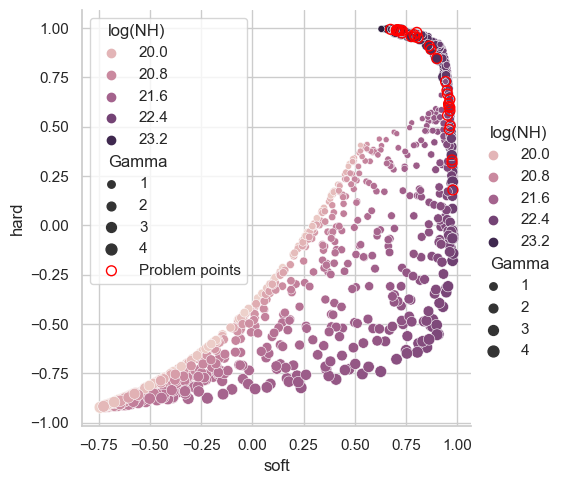

0.5447865221688225

In [50]:
badpoints(RFR, x_test3, data3)

/Users/Eli/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


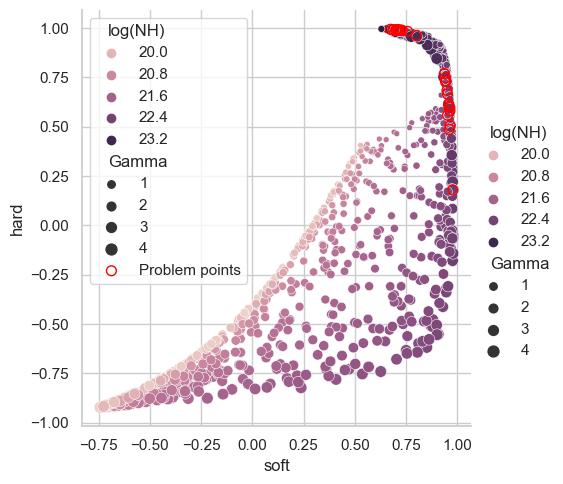

0.5584124526315204

In [51]:
badpoints(poly, x_test3, data3)

### Prediction Accuracy After Filtering

After removing the high-error tail and edge regions, we evaluate the performance of the polynomial regression model. This experiment reveals how much of the model error is driven by challenging regions in the parameter space.


In [52]:
data3wotail = data3[(data3['hard'] < 0.6) & (data3['soft'] < 0.9)]

/Users/Eli/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Cycle 3')

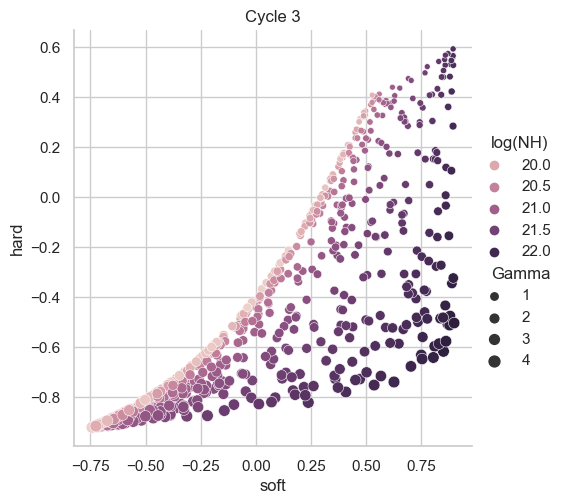

In [53]:
sns.relplot(data=data3wotail, x='soft', y='hard', size='Gamma', hue='log(NH)')
plt.title('Cycle 3')

In [54]:
x_train3, x_test3, y_test3, y_train3=split(data3wotail)

In [55]:
deg3, model3, r23p=kfoldhyperpoly(x_train3, x_test3, y_test3, y_train3, 20)

In [56]:
deg3

9

In [57]:
r23p

0.9975453766997977

In [58]:
poly3=PolynomialFeatures(degree=deg3, include_bias=False)
poly_features3=poly3.fit_transform(x_test3)
ypred3p=model3.predict(poly_features3)
poly=pd.DataFrame()
poly['Gamma']=y_test3[:,0]
poly['log(NH)']=y_test3[:,1]
poly['PGamma']=ypred3p[:,0]
poly['Plog(NH)']=ypred3p[:,1]

In [59]:
mae(y_test3, ypred3p)

0.018929923398149577

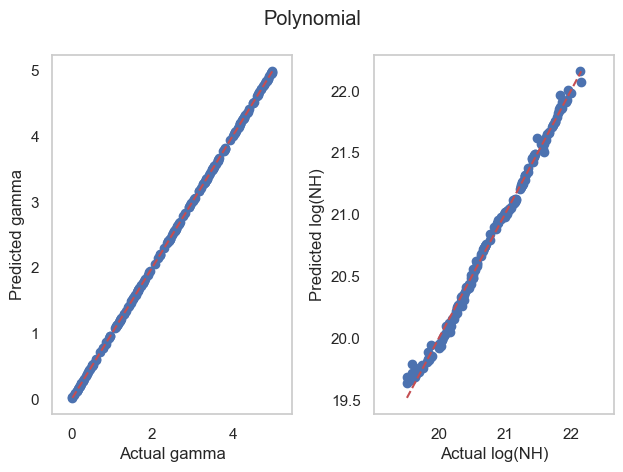

In [60]:
panel(poly, "Polynomial")

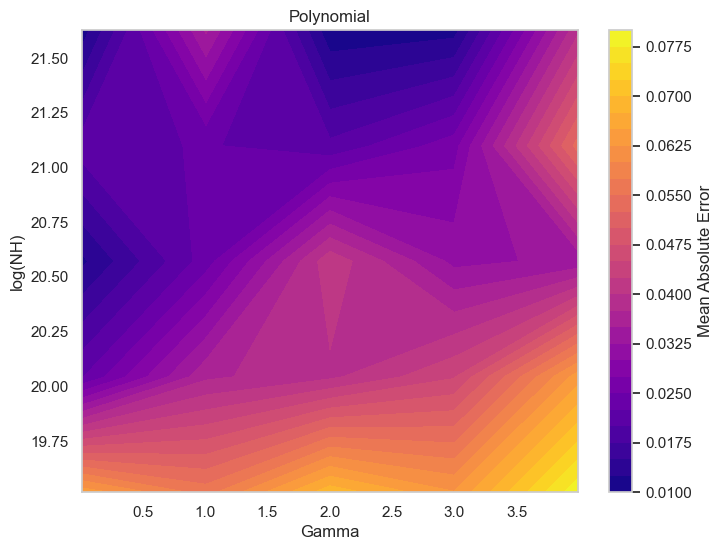

In [61]:
contour(poly, num_bins_x=6, num_bins_y=6, cmap="plasma", title='Polynomial')

/Users/Eli/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


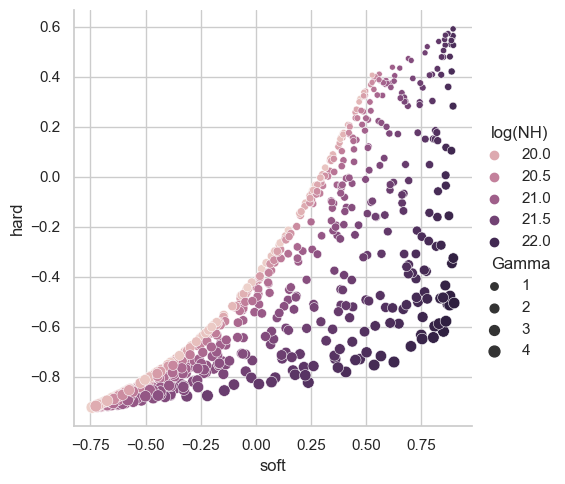

0.30150249550650754

In [62]:
badpoints(poly, x_test3, data3wotail)

## Conclusions

Our results show that machine learning models can effectively estimate $\log(N_H)$ and $\Gamma$ from X-ray colour data.

- **Random Forest Regression** offers the most robust performance across the parameter space.
- **Polynomial Regression** also performs well and is especially effective in smoother regions.
- Models trained on one ObsCycle perform poorly on another, confirming the need for cycle-specific training due to instrumental changes.
- Excluding problematic regions such as the "tail" and "edge" significantly improves predictive accuracy.

This study demonstrates the value of data-driven approaches in astrophysics, especially when traditional fitting methods are limited by data quality or instrument degradation.


### Extracting the polynomial regression equation
The Polynomial is faster to train and the learned parameters can be directly extracted. In this notebook, we export the polynomial coefficients and intercepts into a CSV file (`poly_coefficients_cycle3.csv`), making it easy to reproduce predictions or apply the model outside of Python, such as in spreadsheets or other programming environments.


In [63]:
x_train3, y_train3, x_test3, y_test3=readsplit('train3.csv', 'test3.csv')

In [64]:
deg3, model3, r23p=kfoldhyperpoly(x_train3, x_test3, y_test3, y_train3, 20)

In [65]:
x_train25, y_train25, x_test25, y_test25=readsplit('train25.csv', 'test25.csv')

In [66]:
deg25, model25, r225=kfoldhyperpoly(x_train25, x_test25, y_test25, y_train25, 20)

In [67]:
# Extract coefficients
coefficients = model3.coef_  # Coefficients of the polynomial terms
bias = model3.intercept_  # Bias term

# Print polynomial equation
poly = PolynomialFeatures(degree=deg3)
X_poly = poly.fit_transform(x_train3)  # Transform inputs
feature_names = poly.get_feature_names_out(['H', 'S'])

rows = []
for i, output_name in enumerate(["Nh", "gamma"]):
    row = {'output': output_name, 'bias': bias[i]}
    for name, coef in zip(feature_names, coefficients[i]):
        row[name] = coef
    rows.append(row)

# Convert to DataFrame
df_coef = pd.DataFrame(rows)

# Export to CSV
df_coef.to_csv("poly_coefficients_cycle3.csv", index=False)

print("✅ Polynomial coefficients exported to 'poly_coefficients_cycle3.csv'")

✅ Polynomial coefficients exported to 'poly_coefficients_cycle3.csv'


In [68]:
display(df_coef.head())

,output,bias,1,H,S,H^2,H S,S^2,H^3,H^2 S,...,H^10 S,H^9 S^2,H^8 S^3,H^7 S^4,H^6 S^5,H^5 S^6,H^4 S^7,H^3 S^8,H^2 S^9,H S^10
0,Nh,901.936168,10184.471797,-15150.502600,48294.653263,-150857.234542,110867.834516,123514.805361,-620467.157394,964580.555645,...,13179.455057,58241.935758,-245032.927392,354023.832961,-66334.249615,-420256.871585,478618.290775,-190057.425240,25451.811281,-265.605663
1,gamma,-617.421602,-6122.944207,9496.941995,-24281.154585,81719.815593,-62351.148649,-50590.277708,286902.698284,-478258.920570,...,2560.644686,-9476.758751,29029.241816,-16253.440614,-132251.513913,331246.112161,-334000.869516,166411.242286,-39830.911439,3612.960815


In [69]:
# Extract coefficients
coefficients = model25.coef_  # Coefficients of the polynomial terms
bias = model25.intercept_  # Bias term

# Print polynomial equation
poly = PolynomialFeatures(degree=deg25)
X_poly = poly.fit_transform(x_train25)  # Transform inputs
feature_names = poly.get_feature_names_out(['H', 'S'])

rows = []
for i, output_name in enumerate(["Nh", "gamma"]):
    row = {'output': output_name, 'bias': bias[i]}
    for name, coef in zip(feature_names, coefficients[i]):
        row[name] = coef
    rows.append(row)

# Convert to DataFrame
df_coef = pd.DataFrame(rows)

# Export to CSV
df_coef.to_csv("poly_coefficients_cycle25.csv", index=False)

print("✅ Polynomial coefficients exported to 'poly_coefficients_cycle25.csv'")

✅ Polynomial coefficients exported to 'poly_coefficients_cycle25.csv'


In [70]:
display(df_coef.head())

,output,bias,1,H,S,H^2,H S,S^2,H^3,H^2 S,...,S^8,H^9,H^8 S,H^7 S^2,H^6 S^3,H^5 S^4,H^4 S^5,H^3 S^6,H^2 S^7,H S^8
0,Nh,330100.576288,758095.733321,-2.850896e+06,266499.434743,-6.082037e+06,1.290794e+07,-401900.765819,-3.313792e+06,2.617123e+07,...,421.296380,-15194.857189,140510.665287,-741724.780362,2.051794e+06,-3.993295e+06,6.479164e+06,-8.842339e+06,8.509764e+06,-3.062489e+06
1,gamma,-50279.166609,-60551.646161,1.958723e+05,126013.008031,-2.727523e+04,4.836089e+05,214968.024197,-1.333031e+06,2.716700e+06,...,199.355418,-6187.994625,49024.035847,-194955.625045,5.347485e+05,-1.297953e+06,2.315587e+06,-2.950092e+06,2.694395e+06,-1.082389e+06


In [71]:
deg3

11

In [72]:
deg25

9